# IMDB Top 1000 Movies EDA

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
movie = pd.read_csv("/kaggle/input/imdb-dataset-of-top-1000-movies-and-tv-shows/imdb_top_1000.csv")

## Overview

Overview of variable types, form and checking for missing values

In [3]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB


In [4]:
movie.head(3)

,Poster_Link,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,142 min,Drama,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,"28,341,469"
1,https://m.media-amazon.com/images/M/MV5BM2MyNj...,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
2,https://m.media-amazon.com/images/M/MV5BMTMxNT...,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"


Things to bear in mind:

* Released Year, Runtime, Gross are being treated as objects when it should be numeric of some sort
* Genre is a string which can contain more than one genre
* Meta_Score, Certificate and Gross have missing values
* Star1, Star2, Star3, Star4 may have to be converted to long format


### What to look for

**Questions**

* Does the general public rating (IMDB_Rating) walk hand-in-hand with the specialized critic's ratings (Meta_score)? On what films do these scores differ? Is there a pattern?

* Do highly rated films have a higher gross revenue? What movies don't follow such a pattern?

* What is the relation between the targeted age group and ratings? Do family-friendly films have lower ratings than age-restricted ones?

* Other questions concern Score x Runtime, Released Year x Runtime, Stars in the cast x Revenue, ...

**Statistics**

Formulating the IMDB_score statistic in the following way:

* There is a populational IMDB_Score that we want to estimate and our sample consists of the users who posted their vote on IMDB. In this setting, the precision of the estimate depends on the size of the sample (No_of_Votes), therefore, we must take this into account when comparing two ratings.

## Preprocessing with informal Univariate and Bivariate analysis along the way

Drop unnecessary columns: Poster Link, Overview

In [5]:
movie.drop(["Poster_Link", "Overview"], axis=1, inplace=True)

### Certificate

**Problem**: The variable *certificate* is not standardized, possibly because of the different rating systems across countries and epochs, therefore it depends on the nationality and release year of the film.

In [6]:
movie["Certificate"].value_counts()

Certificate
U           234
A           197
UA          175
R           146
PG-13        43
PG           37
Passed       34
G            12
Approved     11
TV-PG         3
GP            2
TV-14         1
16            1
TV-MA         1
Unrated       1
U/A           1
Name: count, dtype: int64

**Solution**: Aggregate certificates based on the age group they are meant for, inspired by the Brazilian rating system

Looking up the different rating systems and making concessions we have the approximate mapping:

* L: PG, U, G
* 12+: U/A, TV-PG, UA, Passed, Approved
* 14+: PG-13, TV-14
* 16+: 16, A, R, TV-MA
* NaN: Unrated

Sources: 

* https://en.wikipedia.org/wiki/Motion_picture_content_rating_system
* https://en.wikipedia.org/wiki/Central_Board_of_Film_Certification
* https://en.wikipedia.org/wiki/TV_Parental_Guidelines



In [7]:
certificates = {
    "PG": "L", "U": "L", "G": "L",
    "U/A":"12+", "TV-PG":"12+", "UA": "12+", "Passed": "12+", "Approved":"12+",
    "PG-13": "14+", "TV-14":"14+",
    "16":"16+", "A":"16+", "R":"16+", "TV-MA":"16+",
    "Unrated": np.nan
}

In [8]:
movie["Certificate"] = pd.Categorical(movie["Certificate"].map(certificates), categories=["L", "12+", "14+", "16+"],
                                     ordered=True)

<Axes: xlabel='Certificate'>

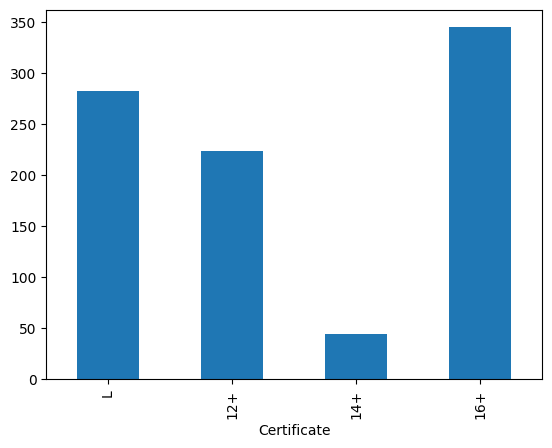

In [9]:
movie["Certificate"].value_counts().sort_index().plot(kind="bar")

Except for 14+ , there seems to be a balanced mix of ratings among the 1000 top IMDB movies. The scarcity of the 14+ badge is probably due to the concessions that had to be made to construct the mapping.

#### Scores x Certificate

<Axes: xlabel='Certificate', ylabel='Meta_score'>

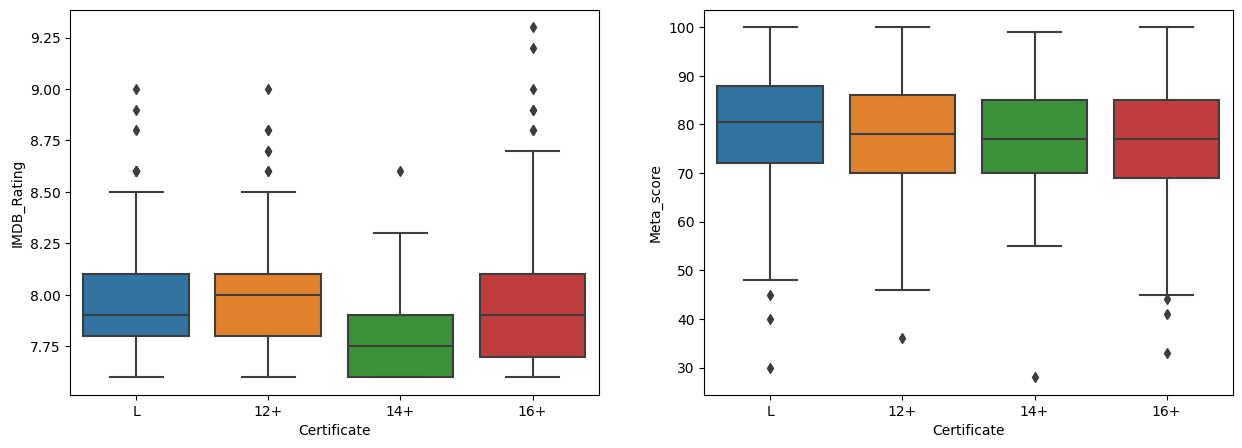

In [10]:
fig = plt.figure(figsize=(15, 5))
ax1, ax2 = fig.subplots(1,2)
sns.boxplot(x="Certificate", y="IMDB_Rating", data=movie, ax=ax1)
sns.boxplot(x="Certificate", y="Meta_score", data=movie, ax=ax2)

Not much here, the difference in ratings among certificates is either small or doesn't follow a clear pattern.

#### Runtime

In [11]:
movie['Runtime'][1]

'175 min'

First, convert the *runtime* variable from string to float 

In [12]:
movie['Runtime'] = movie['Runtime'].map(lambda x: float(x.replace(' min', '')))
movie['Runtime'][1]

175.0

count    1000.000000
mean      122.891000
std        28.093671
min        45.000000
25%       103.000000
50%       119.000000
75%       137.000000
max       321.000000
Name: Runtime, dtype: float64

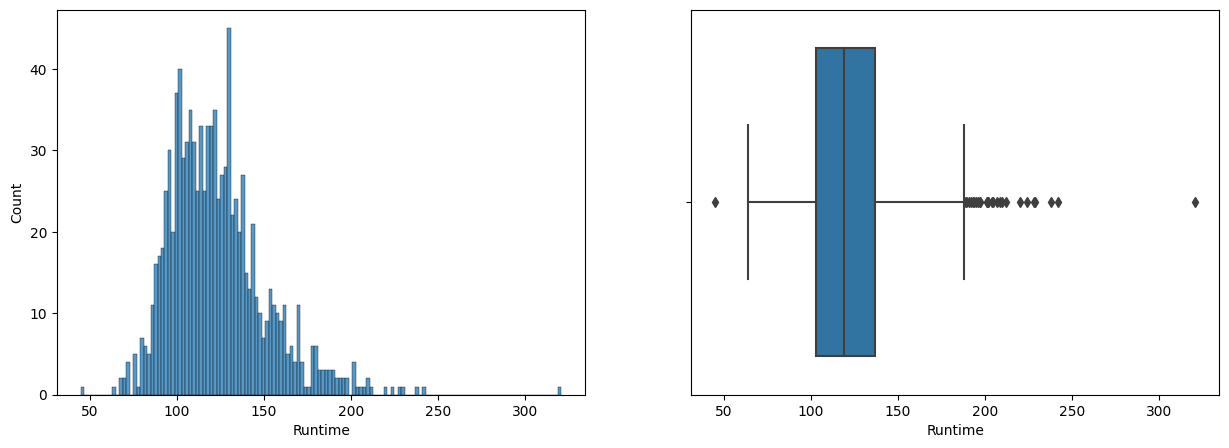

In [13]:
fig = plt.figure(figsize=(15, 5))
ax1, ax2 = fig.subplots(1,2)
sns.histplot(x="Runtime", data=movie, ax=ax1, binwidth=2)
sns.boxplot(x="Runtime", data=movie, ax=ax2);
movie['Runtime'].describe()

On average, movies among the top 1000 rated have a runtime of approximately 2 hours

#### Runtime x Certificate

**Hypothesis**: Family-friendly movies have a shorter runtime than age-restricted ones.

,count,mean,std,min,25%,50%,75%,max
Certificate,,,,,,,,
L,283.0,122.674912,32.152457,72.0,100.0,115.0,137.0,238.0
12+,224.0,124.325893,24.550781,45.0,106.0,124.0,141.0,194.0
14+,44.0,117.295455,25.862408,80.0,101.0,114.0,130.0,242.0
16+,345.0,126.095652,27.424730,80.0,108.0,122.0,139.0,321.0


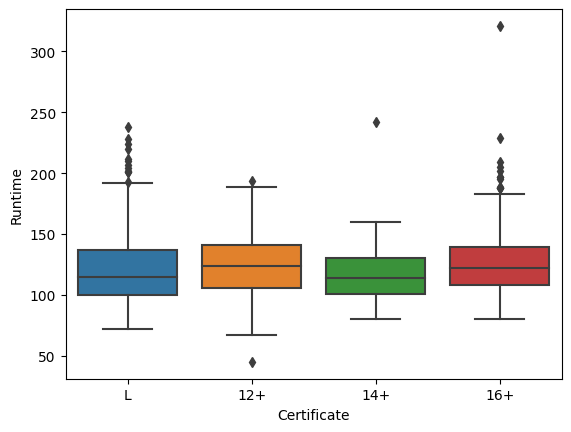

In [14]:
sns.boxplot(x="Certificate", y="Runtime", data=movie);
movie.groupby(by="Certificate")["Runtime"].describe()

Doesn't seem to be the case

#### Released Year

In [15]:
movie['Released_Year'].value_counts()

Released_Year
2014    32
2004    31
2009    29
2013    28
2016    28
        ..
1926     1
1936     1
1924     1
1921     1
PG       1
Name: count, Length: 100, dtype: int64

Released Year is in the string format, before converting to float, there is a value (PG) wrongly inserted that must be dealt with.

In [16]:
movie['Released_Year'] = movie['Released_Year'].map(lambda x: np.nan if x == "PG" else float(x))

#### Runtime x Released Year

**Question**: Are modern films longer than older ones?

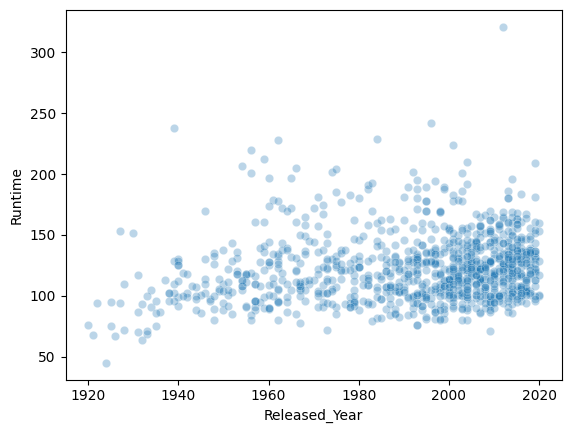

In [17]:
sns.scatterplot(x="Released_Year", y="Runtime", data=movie, alpha=0.3);

There seems to be a mild ascending behavior. Possible guesses for this phenomenon might be:

* Films were harder to produce in the past, therefore they can be shorter on average
* In the beginning, filmmaking was experimental, therefore producers would start small instead of taking a long shot on a lengthy movie.

(Obs: I don't know if that is true, I'd have to talk to a specialist)

However, by following such a reasoning, it is expected that as the film industry matures the average runtime stabilizes, which in practice means that the ascending behavior fades as time goes by. (Like a logarithmic curve).

<Axes: xlabel='Released_Year', ylabel='Runtime'>

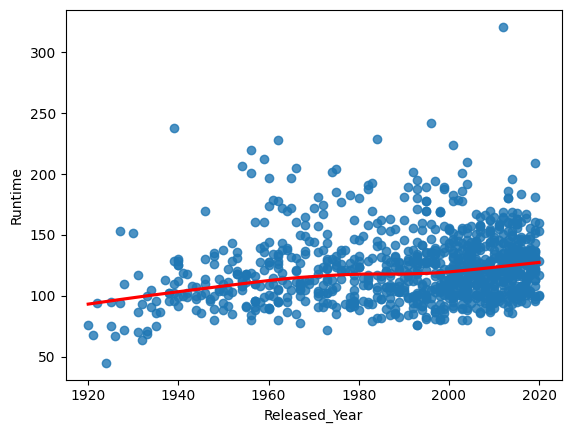

In [18]:
sns.regplot(x="Released_Year", y="Runtime", data=movie, lowess=True, 
            line_kws={'color': 'red'})

The nonparametric regression (lowess) curve makes explicit such dependence.

In [19]:
movie[['Released_Year', 'Runtime']].corr(method='spearman').iloc[0,1]

0.19317359439015597

Calculating Spearman's correlation (a nonparametric version correlation) between Released_Year and Runtime, we have another indication of their positive correlation.